In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Set the global font to be Times New Roman
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 8 
colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

### The impact of Brexit on the UK Foreign Direct Investment (FDI)
---

In [2]:
from src.csc_ipca import CSC_IPCA
from src.csc_ife import CSC_IFE
from src.scm import SCM

In [3]:
# load the data
df = pd.read_csv('data/df_ukfdi.csv')

### 1. Estimate the treatment effect using the CSC-IPCA model
---

In [4]:
# gen a list of covariates
covariates = ['log_gdp', 'import_goods_ser_gdp', 'export_goods_ser_gdp', 'cpi', 'gross_capital_forma_gdp', 'umempoyment_total', 'const']
# add the constant term
df['const'] = 1

In [5]:
# instantiate the model
model = CSC_IPCA()
# set the number of principal components
K = 2

# fit the model
model.fit(df, 'country', 'time', 'fdi_net_gdp', 'treated', covariates, K)
results = df.query("country=='United Kingdom'")[['time', 'fdi_net_gdp']]
results['Y_syn'] = model.predict().flatten()
results['residual'] = results['fdi_net_gdp'] - results['Y_syn']    

In [27]:
# inference

# specify the null hypothesis
nulls = np.linspace(-60, 30, 100)
# estimate the confidence interval use the function class
ci_test = model.inference(nulls, alpha=0.4, n_jobs=-1, verbose=True)

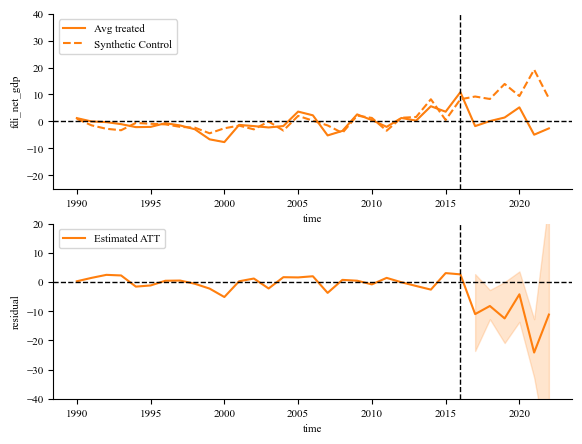

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=df.query("tr_group==1"), x='time', y='fdi_net_gdp', units='country', estimator=None, ax=ax1, legend=False, color=colors[0], linewidth=0.5)
ax1.plot(df.query("tr_group==1").groupby('time').fdi_net_gdp.mean(), color=colors[1], label='Avg treated')

ax1.plot(df.time.unique(), results.Y_syn, color=colors[1], label='Synthetic Control', linestyle='--')
ax1.axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--', linewidth=1)
ax1.axhline(0, color='black', linestyle='--', linewidth=1)
ax1.set(ylim=(-25, 40))
ax1.legend(loc='upper left')

# plot the estimated treatment effect
sns.lineplot(data=results, x='time', y='residual', ax=ax2, color=colors[1], label='Estimated ATT')
ax2.fill_between(ci_test.index, ci_test["60_ci_lower"], ci_test["60_ci_upper"], alpha=0.2,  color="C1")

ax2.axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--', linewidth=1)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set(ylim=(-40, 20))
ax2.legend(loc='upper left')

sns.despine()

### 2. Estimate the treatment effect using the CSC-IFE model
---

In [68]:
# instantiate the model
ife_model = CSC_IFE()
# set the number of principal components
K = 6

# fit the model
ife_model.fit(df, 'country', 'time', 'fdi_net_gdp', 'treated', covariates, K)
results = df.query("country=='United Kingdom'")[['time', 'fdi_net_gdp']]
results['Y_syn'] = ife_model.predict().flatten()
results['residual'] = results['fdi_net_gdp'] - results['Y_syn']    

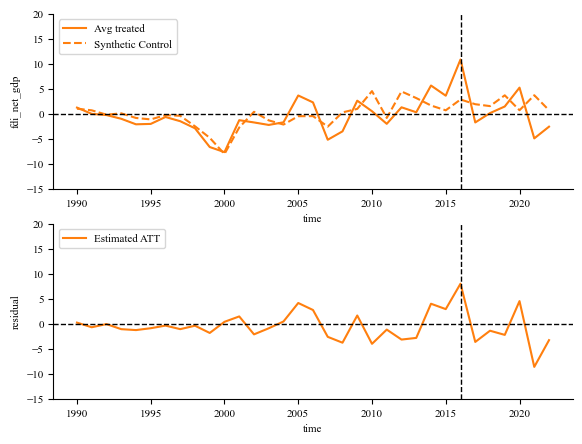

In [69]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=df.query("tr_group==1"), x='time', y='fdi_net_gdp', units='country', estimator=None, ax=ax1, legend=False, color=colors[0], linewidth=0.5)
ax1.plot(df.query("tr_group==1").groupby('time').fdi_net_gdp.mean(), color=colors[1], label='Avg treated')

ax1.plot(df.time.unique(), results.Y_syn, color=colors[1], label='Synthetic Control', linestyle='--')
ax1.axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--', linewidth=1)
ax1.axhline(0, color='black', linestyle='--', linewidth=1)
ax1.set(ylim=(-15, 20))
ax1.legend(loc='upper left')

# plot the estimated treatment effect
sns.lineplot(data=results, x='time', y='residual', ax=ax2, color=colors[1], label='Estimated ATT')
ax2.axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--', linewidth=1)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set(ylim=(-15, 20))
ax2.legend(loc='upper left')

sns.despine()

### 3. Estimate the treatment effect using the synthetic control method
---

In [70]:
# instantiate the model
sc_model = SCM()

# fit the model
sc_model.fit(df, 'country', 'time', 'fdi_net_gdp', 'treated', None)
results = df.query("country=='United Kingdom'")[['time', 'fdi_net_gdp']]
results['Y_syn'] = sc_model.predict().flatten()
results['residual'] = results['fdi_net_gdp'] - results['Y_syn']    

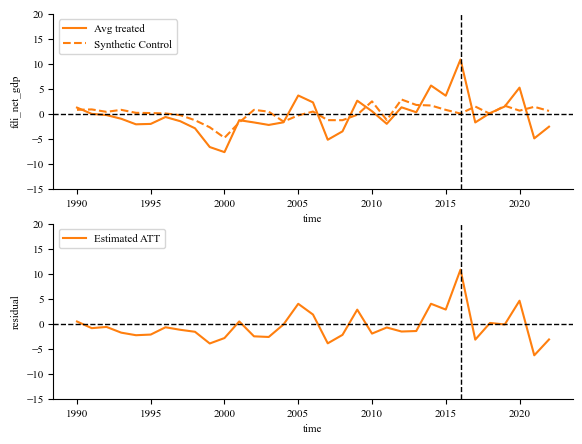

In [71]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=df.query("tr_group==1"), x='time', y='fdi_net_gdp', units='country', estimator=None, ax=ax1, legend=False, color=colors[0], linewidth=0.5)
ax1.plot(df.query("tr_group==1").groupby('time').fdi_net_gdp.mean(), color=colors[1], label='Avg treated')

ax1.plot(df.time.unique(), results.Y_syn, color=colors[1], label='Synthetic Control', linestyle='--')
ax1.axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--', linewidth=1)
ax1.axhline(0, color='black', linestyle='--', linewidth=1)
ax1.set(ylim=(-15, 20))
ax1.legend(loc='upper left')

# plot the estimated treatment effect
sns.lineplot(data=results, x='time', y='residual', ax=ax2, color=colors[1], label='Estimated ATT')
ax2.axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--', linewidth=1)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set(ylim=(-15, 20))
ax2.legend(loc='upper left')

sns.despine()